# 用机器学习做个艺术画家-Prisma(下) 

作者：阿布🐶

阿布量化公众号：abu_quant

未经本人允许禁止转载

In [1]:
from __future__ import division
import matplotlib.pylab as plt
import glob
import os
import itertools
from PrismaWorker import PrismaWorkerClass
import PrismaHelper
import PIL.Image
import numpy as np
from scipy import ndimage
from functools import partial
%matplotlib inline

本章主要针对deepdream的特征识别增强替换做技术探讨，如果我们可以从引导图中发现图像特征，上一章已介绍了如何从图像中寻找特征，但是要想运用特征还需要做很多工作，比如从多个特征中寻找存在的对象，将这个特征融合到另一个图像中做特征融合，这里只做最初步的技术探讨，如果能将特征识别融合做到极致，就可以完成如下假想场景。

1. 抬起头看到天边一朵云，看起来好像我家阿布呢，是不是可以替换一下呢
2. 用手机拍下这朵云，将阿布的照片和云的照片发到云端进行特征识别融合
3. 云端将融合好后的图像发回给用户

流程如下图所示：

![](../show/yg2.jpg)


再次发回给用户的图像类似如下所示：

![](../show/yg.jpg)


[项目git地址](https://github.com/bbfamily/prisma_abu)

1. 基于caffe的google deepdream中的很多Concat层可以把训练好的模型中的很多sharp在输入的图像中进行识别并且融合特征，如inception_4c/output

        layer {
          name: "inception_4c/output"
          type: "Concat"
          bottom: "inception_4c/1x1"
          bottom: "inception_4c/3x3"
          bottom: "inception_4c/5x5"
          bottom: "inception_4c/pool_proj"
          top: "inception_4c/output"
        }
        
    
对inception_4c/1x1(ReLU), inception_4c/3x3(Convolution), inception_4c/5x5(Convolution), inception_4c/pool_proj(Convolution) Concat

[详情网络配置](https://github.com/BVLC/caffe/blob/master/models/bvlc_googlenet/train_val.prototxt)


其实deepdream中把识别出的物体融合到有时我感觉挺可怕的地步，如下iter_n 10，30，100次的对比，话说对不住阿布了，变的这么丑，这特么是狼还是驴阿，头上长犄角身后长尾巴的，不知道有没有人想要我帮他做这种风的格图像呢，如果你需要这样的，也可以把照片发给我，不过你要想好，别吓着自己！

使用abu1.jpg, abu5.jpg作为示例图像，实例化一个PrismaWorkerClass

In [44]:
abu1_fn = '../sample/abu1.jpg'
abu5_fn = '../sample/abu5.jpg'
pw = PrismaWorkerClass()

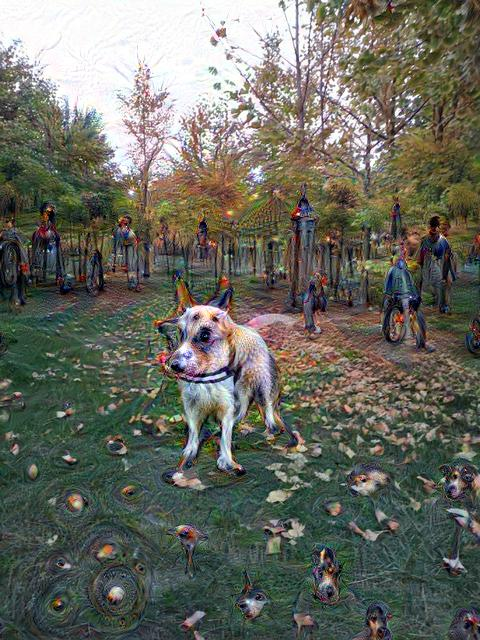

In [43]:
d_img = pw.cp.fit_img(abu1_fn, resize=True, nbk='inception_4c/output', iter_n=10)
PrismaHelper.show_array_ipython(np.float32(d_img))

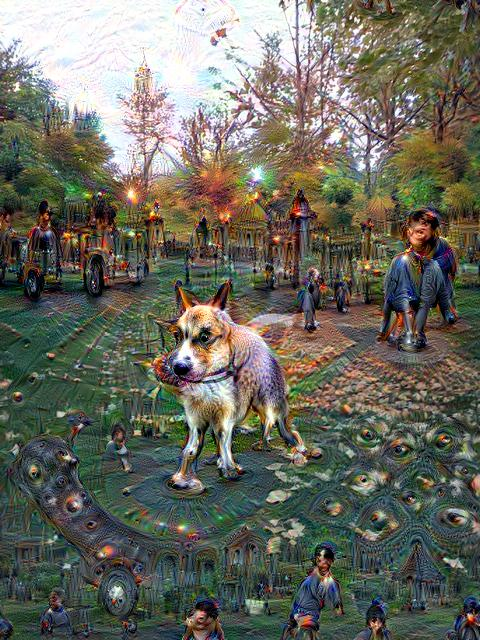

In [45]:
d_img = pw.cp.fit_img(abu1_fn, resize=True, nbk='inception_4c/output', iter_n=30)
PrismaHelper.show_array_ipython(np.float32(d_img))

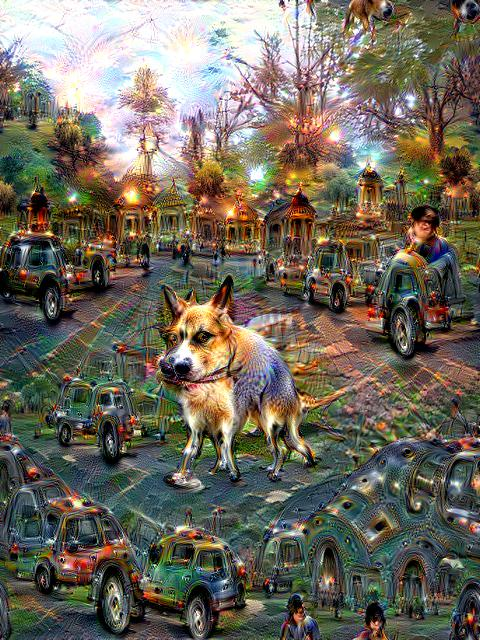

In [46]:
d_img = pw.cp.fit_img(abu1_fn, resize=True, nbk='inception_4c/output', iter_n=100)
PrismaHelper.show_array_ipython(np.float32(d_img))

通过上面特征融合后的图像来看迭代次数越多模型中的sharp融合到输入图像的权重就越大，但是这种方式本身的问题主要还是训练成本高，识别融合效率低，
最后输出不稳定的问题，下面使用图像处理中的一些技术来演示特征融合的过程，希望可以对你有所帮助

### 2. 从图像特征中准确需找物体对象

`find_img_main_feature`将从特征中抽取只包含阿布的图像部分，使用之前PrismaWorkerClass中封装的find_features方法提取特征

* 使用img_cvt > img_cvt.mean()寻找mask
* ndimage.label(mask)对存在的图像进行分类
* 针对阀值找打remove_pixel再使用searchsorted
* 最后使用ndimage.find_objects找到特征图像，代码如下所示



[关于scipy ndimage等使用请参考](https://docs.scipy.org)

备注：这里的函数封装不具备通用性，只是为了方便阅读

In [17]:
def find_img_main_feature(pw, guid_file, threshold=1000, show=False):
    r_img_copy, org_img = pw.find_features(guid_file, loop_factor=1.0, show=show)
    r_img_copy = PIL.Image.fromarray(np.uint8(r_img_copy))

    l_img = np.float32(r_img_copy.convert('L'))
    l_img = np.float32(l_img / 255) 
    img_cvt = pw.do_otsu(r_img_copy, l_img, cb=True)
    
    img_cvt = PIL.Image.fromarray(np.uint8(img_cvt)).convert('L')
    img_cvt = np.float32(img_cvt)

    mask = img_cvt > img_cvt.mean()
    label_cvt, nb_labels = ndimage.label(mask)
    
    sizes = ndimage.sum(mask, label_cvt, range(nb_labels + 1))
    mask_size = sizes < threshold
    remove_pixel = mask_size[label_cvt]
    label_cvt[remove_pixel] = 0
    labels = np.unique(label_cvt)
    label_cvt = np.searchsorted(labels, label_cvt)
    slice_x, slice_y = ndimage.find_objects(label_cvt==np.unique(label_cvt)[-1])[0]

    org_img = np.float32(org_img)
    roi_main = org_img[slice_x, slice_y]
    if show:
        plt.figure(figsize=(4, 2))
        plt.axes([0, 0, 1, 1])
        plt.imshow(roi_main * 255)
        plt.axis('off')

    return roi_main, org_img

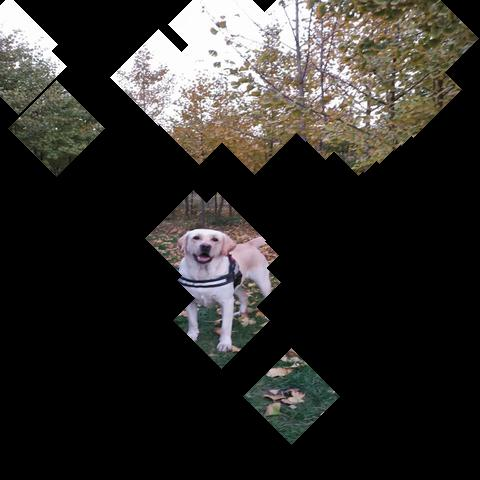

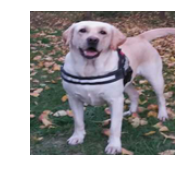

In [18]:
img_cvt, abu1_img = find_img_main_feature(pw, abu1_fn, show=True)

接下来使用相同的方式从abu5中抽取两边两个海洋球的物体对象及其坐标，再次强调这里的函数封装无通用性，只是便于阅读

In [23]:
def suit_img_feature(pw, img_file, threshold=1000, show=False):
    r_img_copy, org_img = pw.find_features(img_file, loop_factor=1.0)
    r_img_copy = PIL.Image.fromarray(np.uint8(r_img_copy))

    l_img = np.float32(r_img_copy.convert('L'))
    l_img = np.float32(l_img / 255) 
    img_cvt = pw.do_otsu(r_img_copy, l_img, cb=True)

    mask = img_cvt > img_cvt.mean()

    label_cvt, nb_labels = ndimage.label(mask)
    sizes = ndimage.sum(mask, label_cvt, range(nb_labels + 1))
    mask_size = sizes < threshold
    remove_pixel = mask_size[label_cvt]
    label_cvt[remove_pixel] = 0
    labels = np.unique(label_cvt)
    print labels
    label_cvt = np.searchsorted(labels, label_cvt)
    print np.unique(label_cvt)

    org_img = np.float32(org_img) * 255
    
    slice_feature1 = ndimage.find_objects(label_cvt==2)[0]
    feature1 = org_img[slice_feature1[0], slice_feature1[1]]
    
    slice_feature12 = ndimage.find_objects(label_cvt==4)[0]
    feature2= org_img[slice_feature12[0], slice_feature12[1]]

    org_img = org_img / 255
    if show:
        plt.figure(figsize=(6, 3))
        plt.subplot(121)
        plt.imshow(feature1)
        plt.axis('off')
        plt.subplot(122)
        plt.imshow(feature2)
        plt.axis('off')
    return org_img, feature1, feature2, slice_feature1, slice_feature12

[  0   1 801 802 803 806]
[0 1 2 3 4 5]


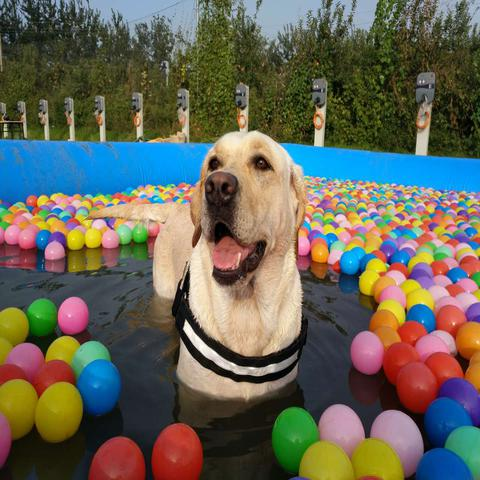

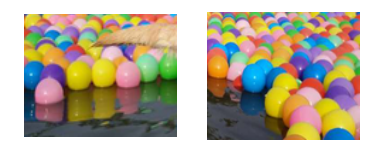

In [26]:
abu5_img, feature1, feature2, slice_feature1, slice_feature2 = suit_img_feature(pw, abu5_fn, threshold=500, show=True)
PrismaHelper.show_array_ipython(np.float32(abu5_img))

### 3. 模型中特征与输入图像特征的融合

接下来将阿布的图像和两个海洋球的图像及坐标传入mix_feature进行特征融合放大

* 将特征之间需要融合的部分进行融合
* 将融合好的新特征带入图像
* 新的图像进行浅层特征放大

In [38]:
def mix_feature(img_cvt, org_img, feature1, feature2, slice_feature1, slice_feature2, threshold=1000, show=False):
    t = PIL.Image.fromarray(np.uint8(img_cvt))
    guide_img = PIL.Image.fromarray(np.uint8(feature1))
    guide_img = guide_img.resize((t.width, t.height), PIL.Image.ANTIALIAS)
    guide_img = np.float32(guide_img)

    mix_feature1 = pw.mix_mask_with_convd(pw.do_otsu, n1=5, n2=22, n3=1, convd_median_factor=1, convd_big_factor=0, 
                             r_img=t, guide_img=guide_img, cb=False, show=show)

    guide_img = PIL.Image.fromarray(np.uint8(feature2))
    guide_img = guide_img.resize((t.width, t.height), PIL.Image.ANTIALIAS)
    guide_img = np.float32(guide_img)

    mix_feature2 = pw.mix_mask_with_convd(pw.do_otsu, n1=5, n2=22, n3=1, convd_median_factor=1, convd_big_factor=0, 
                                       r_img=t, guide_img=guide_img, cb=False, show=show)

    mix_feature1 = PIL.Image.fromarray(np.uint8(mix_feature1)).resize((feature1.shape[1], feature1.shape[0]), PIL.Image.ANTIALIAS)
    mix_feature2 = PIL.Image.fromarray(np.uint8(mix_feature2)).resize((feature2.shape[1], feature2.shape[0]), PIL.Image.ANTIALIAS)

    org_img = np.float32(org_img)

    org_img[slice_feature1[0], slice_feature1[1]] = np.float32(mix_feature1) 
    org_img[slice_feature2[0], slice_feature2[1]] = np.float32(mix_feature2)

    d_img = pw.cp.fit_img(None, resize=True, nbk='conv2/3x3', iter_n=10, img_np=org_img)
    PrismaHelper.show_array_ipython(np.float32(d_img))

整个流程如下图像所示，最后显示出引导图的特征在新的图像中融合的图像

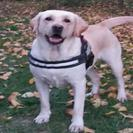

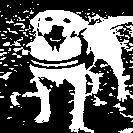

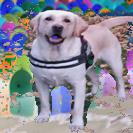

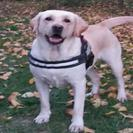

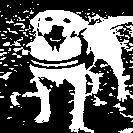

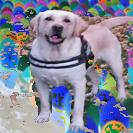

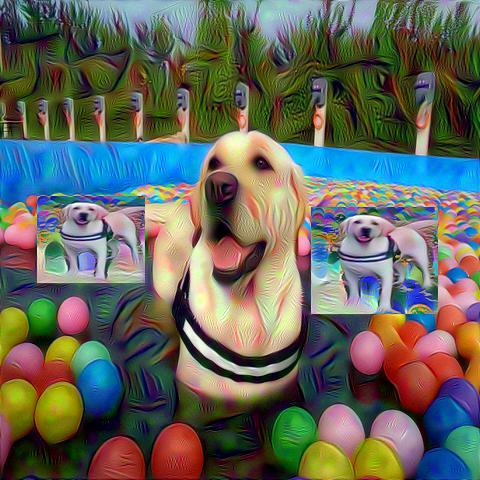

In [37]:
mix_feature(img_cvt, org_img, feature1, feature2, slice_feature1, slice_feature2, show=True)

最后的融合效果并没有惊艳出彩，但是这里只是个演示思路的demo，更多细节处理，比如特征相似度匹配，边缘平滑过度等等都没有使用，这里只是想使用最简单粗暴的方式让你理解一下整个过程。

最后感谢您能有耐心看到这里

### 阿布量化公众号：abu_quant

![](../qrcode.jpg)